## 💻 환경 설정

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import folium
import sys

import geopy
from tqdm import tqdm

from pycaret.regression import *

#경고창이 뜨지 않도록 해주는 것
import warnings
warnings.filterwarnings('ignore')

# notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해주는 것
%matplotlib inline 

>주피터 노트북에서 시각화할때, matplotlib가 한글 폰트 지원하지 않아, 깨짐 처리해줘야 함

In [151]:
import platform                

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False

if platform.system() == 'Darwin': #맥os 사용자의 경우에
    plt.style.use('seaborn-darkgrid') 
    rc('font', family = 'AppleGothic')
    
elif platform.system() == 'Windows':#윈도우 사용자의 경우에
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.style.use('seaborn-darkgrid') # https://python-graph-gallery.com/199-matplotlib-style-sheets/
    rc('font', family=font_name)

> pandas 작업 중 tqdm을 사용하기 위해 다음과 같은 설정을 합니다.

In [152]:
tqdm.pandas()

>복원성을 위해 아래 random_state를 상수로 고정합니다.

In [153]:
RANDOM_STATE= 0
np.random.seed(RANDOM_STATE)

##  💻데이터 불러오기 

In [154]:
df = pd.read_csv('./NYC_taxi_lat_lon.csv') 

In [155]:
df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lat,lon
0,11106,2015-01-01 00:00:00,1,1,3,0,0,75,40.761229,-73.929593
1,10006,2015-01-01 00:00:00,1,1,3,0,0,64,40.708312,-74.013440
2,11201,2015-01-01 00:00:00,1,1,3,0,0,169,40.692500,-73.991763
3,11430,2015-01-01 00:00:00,1,1,3,0,0,222,40.653199,-73.784133
4,10032,2015-01-01 00:00:00,1,1,3,0,0,64,40.837391,-73.941015


In [156]:
df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lat,lon
87015,11219,2015-01-31 23:00:00,1,31,5,23,1,1,40.632650,-73.996601
87016,10456,2015-01-31 23:00:00,1,31,5,23,1,3,40.829743,-73.908570
87017,11355,2015-01-31 23:00:00,1,31,5,23,1,1,40.750423,-73.819936
87018,11210,2015-01-31 23:00:00,1,31,5,23,1,1,40.627427,-73.945651
87019,10167,2015-01-31 23:00:00,1,31,5,23,1,1,40.754649,-73.974771


## 💻 데이터 파악 및 이상유무 확인

In [157]:
df.shape

(87020, 10)

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   zip_code     87020 non-null  int64  
 1   pickup_hour  87020 non-null  object 
 2   month        87020 non-null  int64  
 3   day          87020 non-null  int64  
 4   weekday      87020 non-null  int64  
 5   hour         87020 non-null  int64  
 6   is_weekend   87020 non-null  int64  
 7   cnt          87020 non-null  int64  
 8   lat          87020 non-null  float64
 9   lon          87020 non-null  float64
dtypes: float64(2), int64(7), object(1)
memory usage: 6.6+ MB


> 결측치가 하나도 없습니다.

## 💻 날씨 데이터 불러오기

2015년 1월 뉴욕시의 시간별 날씨 데이터가 필요해 구글링을 통해 해당 정보를 찾았습니다.

> 출처: https://www.kaggle.com/selfishgene/historical-hourly-weather-data

> 해당 데이터는 뉴욕을 포함한 36개의 지역의 날씨 정보(temperature, humidity, pressure, wind_direction, wind_speed)를 가지고 있습니다.

소스: https://www.kaggle.com/selfishgene/historical-hourly-weather-data

In [159]:
temp = pd.read_csv('./archive/temperature.csv')
humid = pd.read_csv('./archive/humidity.csv')
pressure = pd.read_csv('./archive/pressure.csv')
wind_direction = pd.read_csv('./archive/wind_direction.csv')
wind_speed = pd.read_csv('./archive/wind_speed.csv')
des = pd.read_csv('./archive/weather_description.csv')

In [160]:
temp.shape, humid.shape, pressure.shape, wind_direction.shape, wind_speed.shape, des.shape

((45253, 37), (45253, 37), (45253, 37), (45253, 37), (45253, 37), (45253, 37))

In [161]:
weather = pd.concat([temp[['datetime', 'New York']], humid['New York'], pressure['New York'],
                     wind_direction['New York'], wind_speed['New York'], des['New York']],
                    axis=1)
weather.columns = ['datetime', 'temp', 'humid', 'pressure', 'wind_direction', 'wind_speed', 'des']

In [162]:
weather

,datetime,temp,humid,pressure,wind_direction,wind_speed,des
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-10-01 13:00:00,288.220000,58.0,1012.0,260.0,7.0,few clouds
2,2012-10-01 14:00:00,288.247676,57.0,1012.0,260.0,7.0,few clouds
3,2012-10-01 15:00:00,288.326940,57.0,1012.0,260.0,7.0,few clouds
4,2012-10-01 16:00:00,288.406203,57.0,1012.0,260.0,7.0,few clouds
...,...,...,...,...,...,...,...
45248,2017-11-29 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN
45249,2017-11-29 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN
45250,2017-11-29 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN
45251,2017-11-29 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [163]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   datetime        45253 non-null  object 
 1   temp            44460 non-null  float64
 2   humid           43629 non-null  float64
 3   pressure        44212 non-null  float64
 4   wind_direction  44460 non-null  float64
 5   wind_speed      44460 non-null  float64
 6   des             44460 non-null  object 
dtypes: float64(5), object(2)
memory usage: 2.4+ MB


In [164]:
weather = weather.loc[ (weather['datetime'] > '2015-01-01 00:00') & (weather['datetime'] < '2015-02-01 00:00')]
weather

,datetime,temp,humid,pressure,wind_direction,wind_speed,des
19716,2015-01-01 00:00:00,268.050000,59.0,1022.0,249.0,2.0,sky is clear
19717,2015-01-01 01:00:00,268.050000,59.0,1022.0,249.0,2.0,sky is clear
19718,2015-01-01 02:00:00,267.186000,58.0,1021.0,246.0,2.0,sky is clear
19719,2015-01-01 03:00:00,267.186000,58.0,1021.0,246.0,2.0,sky is clear
19720,2015-01-01 04:00:00,267.186000,58.0,1021.0,246.0,2.0,sky is clear
...,...,...,...,...,...,...,...
20455,2015-01-31 19:00:00,268.625000,99.0,1032.0,313.0,6.0,sky is clear
20456,2015-01-31 20:00:00,268.744000,99.0,1032.0,312.0,5.0,sky is clear
20457,2015-01-31 21:00:00,267.338310,83.0,1024.0,311.0,4.0,sky is clear
20458,2015-01-31 22:00:00,266.707000,74.0,1020.0,310.0,3.0,sky is clear


## 💻 기존 데이터셋과 합치기

In [165]:
df

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lat,lon
0,11106,2015-01-01 00:00:00,1,1,3,0,0,75,40.761229,-73.929593
1,10006,2015-01-01 00:00:00,1,1,3,0,0,64,40.708312,-74.013440
2,11201,2015-01-01 00:00:00,1,1,3,0,0,169,40.692500,-73.991763
3,11430,2015-01-01 00:00:00,1,1,3,0,0,222,40.653199,-73.784133
4,10032,2015-01-01 00:00:00,1,1,3,0,0,64,40.837391,-73.941015
...,...,...,...,...,...,...,...,...,...,...
87015,11219,2015-01-31 23:00:00,1,31,5,23,1,1,40.632650,-73.996601
87016,10456,2015-01-31 23:00:00,1,31,5,23,1,3,40.829743,-73.908570
87017,11355,2015-01-31 23:00:00,1,31,5,23,1,1,40.750423,-73.819936
87018,11210,2015-01-31 23:00:00,1,31,5,23,1,1,40.627427,-73.945651


> 기존 df의 순서를 지키며 merge

In [166]:
df = df.merge(df.merge(weather, how='left', left_on='pickup_hour', right_on='datetime', sort=False))

In [167]:
del df['datetime']

In [168]:
df

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lat,lon,temp,humid,pressure,wind_direction,wind_speed,des
0,11106,2015-01-01 00:00:00,1,1,3,0,0,75,40.761229,-73.929593,268.050000,59.0,1022.0,249.0,2.0,sky is clear
1,10006,2015-01-01 00:00:00,1,1,3,0,0,64,40.708312,-74.013440,268.050000,59.0,1022.0,249.0,2.0,sky is clear
2,11201,2015-01-01 00:00:00,1,1,3,0,0,169,40.692500,-73.991763,268.050000,59.0,1022.0,249.0,2.0,sky is clear
3,11430,2015-01-01 00:00:00,1,1,3,0,0,222,40.653199,-73.784133,268.050000,59.0,1022.0,249.0,2.0,sky is clear
4,10032,2015-01-01 00:00:00,1,1,3,0,0,64,40.837391,-73.941015,268.050000,59.0,1022.0,249.0,2.0,sky is clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87015,11219,2015-01-31 23:00:00,1,31,5,23,1,1,40.632650,-73.996601,266.974481,81.0,1024.0,309.0,4.0,sky is clear
87016,10456,2015-01-31 23:00:00,1,31,5,23,1,3,40.829743,-73.908570,266.974481,81.0,1024.0,309.0,4.0,sky is clear
87017,11355,2015-01-31 23:00:00,1,31,5,23,1,1,40.750423,-73.819936,266.974481,81.0,1024.0,309.0,4.0,sky is clear
87018,11210,2015-01-31 23:00:00,1,31,5,23,1,1,40.627427,-73.945651,266.974481,81.0,1024.0,309.0,4.0,sky is clear


## 💻 데이터 형태/단위 가공

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87020 entries, 0 to 87019
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   zip_code        87020 non-null  int64  
 1   pickup_hour     87020 non-null  object 
 2   month           87020 non-null  int64  
 3   day             87020 non-null  int64  
 4   weekday         87020 non-null  int64  
 5   hour            87020 non-null  int64  
 6   is_weekend      87020 non-null  int64  
 7   cnt             87020 non-null  int64  
 8   lat             87020 non-null  float64
 9   lon             87020 non-null  float64
 10  temp            87020 non-null  float64
 11  humid           87020 non-null  float64
 12  pressure        87020 non-null  float64
 13  wind_direction  87020 non-null  float64
 14  wind_speed      87020 non-null  float64
 15  des             87020 non-null  object 
dtypes: float64(7), int64(7), object(2)
memory usage: 11.3+ MB


> wind_direction이 0 ~ 360으로 되어 있는데, 모델 입장에서는 1도와 359도(2도 차이)보다 1도와 100도(99도 차이)를 더 가깝게 인식할 것이므로, 이를 적절히 수정할 필요가 있습니다.

> 바람 방향(각도)를 해당 각으로 원점에서 출발한 벡터가 단위원과 만나는 x,y 좌표로 바꿔줍니다. 

In [170]:
import math

def degree_to_x(row):
    degree = row['wind_direction']
    x = math.cos(math.radians(degree))
    return x

def degree_to_y(row):
    degree = row['wind_direction']
    y = math.sin(math.radians(degree))
    return y

In [171]:
df['wind_x'] = df.progress_apply(degree_to_x, axis=1)
df['wind_y'] = df.progress_apply(degree_to_y, axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 87020/87020 [00:02<00:00, 43466.56it/s]


In [172]:
df

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lat,lon,temp,humid,pressure,wind_direction,wind_speed,des,wind_x,wind_y
0,11106,2015-01-01 00:00:00,1,1,3,0,0,75,40.761229,-73.929593,268.050000,59.0,1022.0,249.0,2.0,sky is clear,-0.358368,-0.933580
1,10006,2015-01-01 00:00:00,1,1,3,0,0,64,40.708312,-74.013440,268.050000,59.0,1022.0,249.0,2.0,sky is clear,-0.358368,-0.933580
2,11201,2015-01-01 00:00:00,1,1,3,0,0,169,40.692500,-73.991763,268.050000,59.0,1022.0,249.0,2.0,sky is clear,-0.358368,-0.933580
3,11430,2015-01-01 00:00:00,1,1,3,0,0,222,40.653199,-73.784133,268.050000,59.0,1022.0,249.0,2.0,sky is clear,-0.358368,-0.933580
4,10032,2015-01-01 00:00:00,1,1,3,0,0,64,40.837391,-73.941015,268.050000,59.0,1022.0,249.0,2.0,sky is clear,-0.358368,-0.933580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87015,11219,2015-01-31 23:00:00,1,31,5,23,1,1,40.632650,-73.996601,266.974481,81.0,1024.0,309.0,4.0,sky is clear,0.629320,-0.777146
87016,10456,2015-01-31 23:00:00,1,31,5,23,1,3,40.829743,-73.908570,266.974481,81.0,1024.0,309.0,4.0,sky is clear,0.629320,-0.777146
87017,11355,2015-01-31 23:00:00,1,31,5,23,1,1,40.750423,-73.819936,266.974481,81.0,1024.0,309.0,4.0,sky is clear,0.629320,-0.777146
87018,11210,2015-01-31 23:00:00,1,31,5,23,1,1,40.627427,-73.945651,266.974481,81.0,1024.0,309.0,4.0,sky is clear,0.629320,-0.777146


데이터의 단위:

>① Humidity (%), ② Pressure (hPa), ③ Temperature (K), ④ Wind Direction (meteorological degrees), ⑤ Wind Speed (m/s).

> temperature의 단위가 현재 Kelvin으로 되어 있어 이를 Celcius로 변환하겠습니다. 

In [173]:
df['temp'] = df['temp'] - 273.15

In [174]:
df

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lat,lon,temp,humid,pressure,wind_direction,wind_speed,des,wind_x,wind_y
0,11106,2015-01-01 00:00:00,1,1,3,0,0,75,40.761229,-73.929593,-5.100000,59.0,1022.0,249.0,2.0,sky is clear,-0.358368,-0.933580
1,10006,2015-01-01 00:00:00,1,1,3,0,0,64,40.708312,-74.013440,-5.100000,59.0,1022.0,249.0,2.0,sky is clear,-0.358368,-0.933580
2,11201,2015-01-01 00:00:00,1,1,3,0,0,169,40.692500,-73.991763,-5.100000,59.0,1022.0,249.0,2.0,sky is clear,-0.358368,-0.933580
3,11430,2015-01-01 00:00:00,1,1,3,0,0,222,40.653199,-73.784133,-5.100000,59.0,1022.0,249.0,2.0,sky is clear,-0.358368,-0.933580
4,10032,2015-01-01 00:00:00,1,1,3,0,0,64,40.837391,-73.941015,-5.100000,59.0,1022.0,249.0,2.0,sky is clear,-0.358368,-0.933580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87015,11219,2015-01-31 23:00:00,1,31,5,23,1,1,40.632650,-73.996601,-6.175519,81.0,1024.0,309.0,4.0,sky is clear,0.629320,-0.777146
87016,10456,2015-01-31 23:00:00,1,31,5,23,1,3,40.829743,-73.908570,-6.175519,81.0,1024.0,309.0,4.0,sky is clear,0.629320,-0.777146
87017,11355,2015-01-31 23:00:00,1,31,5,23,1,1,40.750423,-73.819936,-6.175519,81.0,1024.0,309.0,4.0,sky is clear,0.629320,-0.777146
87018,11210,2015-01-31 23:00:00,1,31,5,23,1,1,40.627427,-73.945651,-6.175519,81.0,1024.0,309.0,4.0,sky is clear,0.629320,-0.777146


In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87020 entries, 0 to 87019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   zip_code        87020 non-null  int64  
 1   pickup_hour     87020 non-null  object 
 2   month           87020 non-null  int64  
 3   day             87020 non-null  int64  
 4   weekday         87020 non-null  int64  
 5   hour            87020 non-null  int64  
 6   is_weekend      87020 non-null  int64  
 7   cnt             87020 non-null  int64  
 8   lat             87020 non-null  float64
 9   lon             87020 non-null  float64
 10  temp            87020 non-null  float64
 11  humid           87020 non-null  float64
 12  pressure        87020 non-null  float64
 13  wind_direction  87020 non-null  float64
 14  wind_speed      87020 non-null  float64
 15  des             87020 non-null  object 
 16  wind_x          87020 non-null  float64
 17  wind_y          87020 non-null 

> weather description string을 적절히 가공해줍니다. 다행히 결측치는 없습니다.

> 놀랍게도 10개의 값 밖에 없습니다.

In [176]:
df['des'].unique()

array(['sky is clear', 'few clouds', 'broken clouds', 'overcast clouds',
       'light rain', 'moderate rain', 'heavy intensity rain',
       'light snow', 'scattered clouds', 'snow'], dtype=object)

In [177]:
df['des'].value_counts()

sky is clear            42241
overcast clouds         10431
broken clouds            9225
few clouds               8197
scattered clouds         7500
light rain               3996
moderate rain            2737
snow                     1661
heavy intensity rain      588
light snow                444
Name: des, dtype: int64

> 추후 원활한 가공을 위해 띄어쓰기를 언더바로 바꿔줍니다.

In [178]:
def space_to_underscore(row):
    des = row['des']
    des = des.replace(" ", "_")
    return des

In [179]:
df['des'] = df.progress_apply(space_to_underscore, axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 87020/87020 [00:01<00:00, 50300.65it/s]


In [180]:
df['des'].unique()

array(['sky_is_clear', 'few_clouds', 'broken_clouds', 'overcast_clouds',
       'light_rain', 'moderate_rain', 'heavy_intensity_rain',
       'light_snow', 'scattered_clouds', 'snow'], dtype=object)

> 4가지 구분(clear/cloud/rain/snow)을 새로운 열로 추가해줍니다.

In [181]:
df['is_raining'] = (df['des'].str.contains('rain')).astype(int)
df['is_snowing'] = (df['des'].str.contains('snow')).astype(int)
df['is_cloudy'] = (df['des'].str.contains('cloud')).astype(int)
df['is_clear'] = (df['des'].str.contains('clear')).astype(int)

In [182]:
df

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lat,lon,temp,humid,pressure,wind_direction,wind_speed,des,wind_x,wind_y,is_raining,is_snowing,is_cloudy,is_clear
0,11106,2015-01-01 00:00:00,1,1,3,0,0,75,40.761229,-73.929593,-5.100000,59.0,1022.0,249.0,2.0,sky_is_clear,-0.358368,-0.933580,0,0,0,1
1,10006,2015-01-01 00:00:00,1,1,3,0,0,64,40.708312,-74.013440,-5.100000,59.0,1022.0,249.0,2.0,sky_is_clear,-0.358368,-0.933580,0,0,0,1
2,11201,2015-01-01 00:00:00,1,1,3,0,0,169,40.692500,-73.991763,-5.100000,59.0,1022.0,249.0,2.0,sky_is_clear,-0.358368,-0.933580,0,0,0,1
3,11430,2015-01-01 00:00:00,1,1,3,0,0,222,40.653199,-73.784133,-5.100000,59.0,1022.0,249.0,2.0,sky_is_clear,-0.358368,-0.933580,0,0,0,1
4,10032,2015-01-01 00:00:00,1,1,3,0,0,64,40.837391,-73.941015,-5.100000,59.0,1022.0,249.0,2.0,sky_is_clear,-0.358368,-0.933580,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87015,11219,2015-01-31 23:00:00,1,31,5,23,1,1,40.632650,-73.996601,-6.175519,81.0,1024.0,309.0,4.0,sky_is_clear,0.629320,-0.777146,0,0,0,1
87016,10456,2015-01-31 23:00:00,1,31,5,23,1,3,40.829743,-73.908570,-6.175519,81.0,1024.0,309.0,4.0,sky_is_clear,0.629320,-0.777146,0,0,0,1
87017,11355,2015-01-31 23:00:00,1,31,5,23,1,1,40.750423,-73.819936,-6.175519,81.0,1024.0,309.0,4.0,sky_is_clear,0.629320,-0.777146,0,0,0,1
87018,11210,2015-01-31 23:00:00,1,31,5,23,1,1,40.627427,-73.945651,-6.175519,81.0,1024.0,309.0,4.0,sky_is_clear,0.629320,-0.777146,0,0,0,1


> 각 단계를 다음 순서(수위)에 따라 0~9로 레이블한 열을 새로운 열로 추가해줍니다.

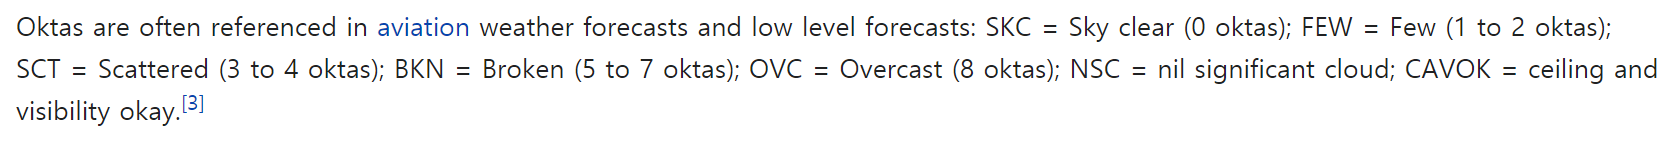

+ sky_is_clear
+ few_clouds
+ scattered_clouds
+ broken_clouds
+ overcast_clouds
+ light_snow
+ light_rain
+ moderate_rain
+ snow
+ heavy_intensity_rain

In [183]:
def description_to_label(row):
     return {
        'sky_is_clear': 0,
        'few_clouds': 1,
        'scattered_clouds': 2,
        'broken_clouds': 3, 
        'overcast_clouds': 4,
        'light_snow': 5,
        'light_rain': 6,
        'moderate_rain': 7,
        'snow': 8,
        'heavy_intensity_rain': 9,
    }.get(row['des'], -1)

In [184]:
df['weather_strength'] = df.progress_apply(description_to_label, axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 87020/87020 [00:01<00:00, 45346.55it/s]


In [185]:
df

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lat,lon,temp,humid,pressure,wind_direction,wind_speed,des,wind_x,wind_y,is_raining,is_snowing,is_cloudy,is_clear,weather_strength
0,11106,2015-01-01 00:00:00,1,1,3,0,0,75,40.761229,-73.929593,-5.100000,59.0,1022.0,249.0,2.0,sky_is_clear,-0.358368,-0.933580,0,0,0,1,0
1,10006,2015-01-01 00:00:00,1,1,3,0,0,64,40.708312,-74.013440,-5.100000,59.0,1022.0,249.0,2.0,sky_is_clear,-0.358368,-0.933580,0,0,0,1,0
2,11201,2015-01-01 00:00:00,1,1,3,0,0,169,40.692500,-73.991763,-5.100000,59.0,1022.0,249.0,2.0,sky_is_clear,-0.358368,-0.933580,0,0,0,1,0
3,11430,2015-01-01 00:00:00,1,1,3,0,0,222,40.653199,-73.784133,-5.100000,59.0,1022.0,249.0,2.0,sky_is_clear,-0.358368,-0.933580,0,0,0,1,0
4,10032,2015-01-01 00:00:00,1,1,3,0,0,64,40.837391,-73.941015,-5.100000,59.0,1022.0,249.0,2.0,sky_is_clear,-0.358368,-0.933580,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87015,11219,2015-01-31 23:00:00,1,31,5,23,1,1,40.632650,-73.996601,-6.175519,81.0,1024.0,309.0,4.0,sky_is_clear,0.629320,-0.777146,0,0,0,1,0
87016,10456,2015-01-31 23:00:00,1,31,5,23,1,3,40.829743,-73.908570,-6.175519,81.0,1024.0,309.0,4.0,sky_is_clear,0.629320,-0.777146,0,0,0,1,0
87017,11355,2015-01-31 23:00:00,1,31,5,23,1,1,40.750423,-73.819936,-6.175519,81.0,1024.0,309.0,4.0,sky_is_clear,0.629320,-0.777146,0,0,0,1,0
87018,11210,2015-01-31 23:00:00,1,31,5,23,1,1,40.627427,-73.945651,-6.175519,81.0,1024.0,309.0,4.0,sky_is_clear,0.629320,-0.777146,0,0,0,1,0


## 💻 후처리

> 1월 1일(New Year's Day), 1월 19일(Martin Luther King Day) 공휴일로 지정

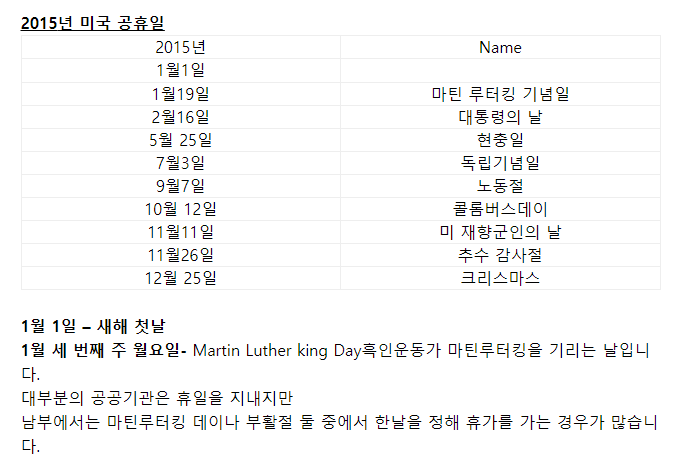

In [190]:
df.loc[(df['pickup_hour'] > '2015-01-01 00:00') & (df['pickup_hour'] < '2015-01-02 00:00'), 'is_weekend'] = 1
df.loc[(df['pickup_hour'] > '2015-01-01 00:00') & (df['pickup_hour'] < '2015-01-02 00:00')]

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lat,lon,temp,humid,pressure,wind_direction,wind_speed,des,wind_x,wind_y,is_raining,is_snowing,is_cloudy,is_clear,weather_strength
0,11106,2015-01-01 00:00:00,1,1,3,0,1,75,40.761229,-73.929593,-5.100,59.0,1022.0,249.0,2.0,sky_is_clear,-0.358368,-0.93358,0,0,0,1,0
1,10006,2015-01-01 00:00:00,1,1,3,0,1,64,40.708312,-74.013440,-5.100,59.0,1022.0,249.0,2.0,sky_is_clear,-0.358368,-0.93358,0,0,0,1,0
2,11201,2015-01-01 00:00:00,1,1,3,0,1,169,40.692500,-73.991763,-5.100,59.0,1022.0,249.0,2.0,sky_is_clear,-0.358368,-0.93358,0,0,0,1,0
3,11430,2015-01-01 00:00:00,1,1,3,0,1,222,40.653199,-73.784133,-5.100,59.0,1022.0,249.0,2.0,sky_is_clear,-0.358368,-0.93358,0,0,0,1,0
4,10032,2015-01-01 00:00:00,1,1,3,0,1,64,40.837391,-73.941015,-5.100,59.0,1022.0,249.0,2.0,sky_is_clear,-0.358368,-0.93358,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,10279,2015-01-01 23:00:00,1,1,3,23,1,2,40.712369,-74.008401,-0.396,58.0,1015.0,241.0,3.0,sky_is_clear,-0.484810,-0.87462,0,0,0,1,0
3229,11237,2015-01-01 23:00:00,1,1,3,23,1,4,40.701298,-73.918203,-0.396,58.0,1015.0,241.0,3.0,sky_is_clear,-0.484810,-0.87462,0,0,0,1,0
3230,10454,2015-01-01 23:00:00,1,1,3,23,1,3,40.807741,-73.918223,-0.396,58.0,1015.0,241.0,3.0,sky_is_clear,-0.484810,-0.87462,0,0,0,1,0
3231,10453,2015-01-01 23:00:00,1,1,3,23,1,3,40.852335,-73.911997,-0.396,58.0,1015.0,241.0,3.0,sky_is_clear,-0.484810,-0.87462,0,0,0,1,0


In [191]:
df.loc[(df['pickup_hour'] > '2015-01-19 00:00') & (df['pickup_hour'] < '2015-01-20 00:00'), 'is_weekend'] = 1
df.loc[(df['pickup_hour'] > '2015-01-19 00:00') & (df['pickup_hour'] < '2015-01-20 00:00')]

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lat,lon,temp,humid,pressure,wind_direction,wind_speed,des,wind_x,wind_y,is_raining,is_snowing,is_cloudy,is_clear,weather_strength
51332,10031,2015-01-19 00:00:00,1,19,0,0,1,36,40.825310,-73.948360,1.829,92.0,1004.0,275.0,2.0,moderate_rain,0.087156,-0.996195,1,0,0,0,7
51333,10014,2015-01-19 00:00:00,1,19,0,0,1,691,40.734090,-74.004893,1.829,92.0,1004.0,275.0,2.0,moderate_rain,0.087156,-0.996195,1,0,0,0,7
51334,11220,2015-01-19 00:00:00,1,19,0,0,1,1,40.641191,-74.012799,1.829,92.0,1004.0,275.0,2.0,moderate_rain,0.087156,-0.996195,1,0,0,0,7
51335,10019,2015-01-19 00:00:00,1,19,0,0,1,753,40.763992,-73.985893,1.829,92.0,1004.0,275.0,2.0,moderate_rain,0.087156,-0.996195,1,0,0,0,7
51336,10013,2015-01-19 00:00:00,1,19,0,0,1,246,40.723075,-74.009359,1.829,92.0,1004.0,275.0,2.0,moderate_rain,0.087156,-0.996195,1,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54138,10154,2015-01-19 23:00:00,1,19,0,23,1,12,40.757866,-73.972311,-1.226,78.0,1010.0,291.0,3.0,sky_is_clear,0.358368,-0.933580,0,0,0,1,0
54139,11369,2015-01-19 23:00:00,1,19,0,23,1,5,40.762495,-73.872836,-1.226,78.0,1010.0,291.0,3.0,sky_is_clear,0.358368,-0.933580,0,0,0,1,0
54140,11368,2015-01-19 23:00:00,1,19,0,23,1,2,40.748088,-73.860623,-1.226,78.0,1010.0,291.0,3.0,sky_is_clear,0.358368,-0.933580,0,0,0,1,0
54141,11693,2015-01-19 23:00:00,1,19,0,23,1,1,40.598656,-73.817860,-1.226,78.0,1010.0,291.0,3.0,sky_is_clear,0.358368,-0.933580,0,0,0,1,0


## 💻 추가된 정보로 csv 파일 생성

In [192]:
df.to_csv('NYC_taxi_extra_info.csv', index=False)